In [13]:
import pymc3 as pm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats

In [2]:
#example 8.1
#compare gaussian means
#fictional data set about seasonal memory model
#increase glucose in the summer increases  recall
#data below
Winter = np.array([-0.05, 0.41, 0.17, -0.13, 0.00, -0.05, 0.00, 0.17, 0.29, 0.04, 0.21, 0.08, 0.37, 0.17, 0.08, -0.04, -0.04, 0.04, -0.13, -0.12, 0.04, 0.21, 0.17, 0.17, 0.17, 0.33, 0.04, 0.04, 0.04, 0.00, 0.21, 0.13, 0.25, -0.05, 0.29, 0.42, -0.05, 0.12, 0.04, 0.25, 0.12])
Summer = np.array([0.00, 0.38, -0.12, 0.12, 0.25, 0.12, 0.13, 0.37, 0.00, 0.50, 0.00, 0.00, -0.13, -0.37, -0.25, -0.12, 0.50, 0.25, 0.13, 0.25, 0.25, 0.38, 0.25, 0.12, 0.00, 0.00, 0.00, 0.00, 0.25, 0.13, -0.25, -0.38, -0.13, -0.25, 0.00, 0.00, -0.12, 0.25, 0.00, 0.50, 0.00])

#Allowed because it is a within-subjects design
x = Winter - Summer
x = x/np.std(x); # Standardize

In [3]:
with pm.Model() as model:
    effect_size = pm.Cauchy('effect_size',alpha=0,beta=1)
    std_dev = pm.HalfCauchy('std', beta=1)
    mu = effect_size * std_dev
    norm_distribution = pm.Normal('norm_obs', mu=mu, sd=std_dev, observed=x)
    prior_effect_size = pm.Cauchy('prior_effect_size',alpha=0,beta=1)

In [4]:
with model:
    trace = pm.sample(10000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [prior_effect_size, std, effect_size]
Sampling 2 chains: 100%|██████████| 21000/21000 [01:27<00:00, 241.25draws/s]
/anaconda3/lib/python3.7/site-packages/mkl_fft/_numpy_fft.py:1044: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  output = mkl_fft.rfftn_numpy(a, s, axes)
The acceptance probability does not match the target. It is 0.41675764473806315, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9142594777742089, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 10% for some parameters.


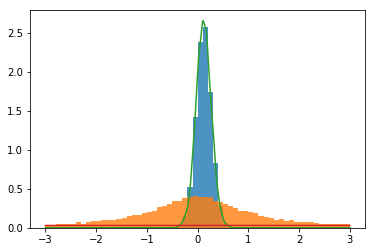

In [40]:

x_range = (-3,3)
num_bins = 60
hist_args = {'density':1,'range':x_range, 'bins': num_bins, 'alpha':.8}
plt.hist(trace['effect_size'], **hist_args)
plt.hist(trace['prior_effect_size'], **hist_args)
#kde for actual effect size
kde_prior_effect = stats.gaussian_kde(trace['prior_effect_size'][:])
kde_effect = stats.gaussian_kde(trace['effect_size'])
kde_plot_x = np.linspace(-3, 3, 1000)
plt.plot(kde_plot_x, kde_effect(kde_plot_x))
#TODO find method to provide smooth estimates for cauchy priors
plt.plot(kde_plot_x, kde_prior_effect(kde_plot_x))
#Bayes factor of approximately 5 (Ho aproximately 2.5, H1 approximately .5) 
#in support of the null hypothesis (Ho effect size = 0,H1 ~ Cauchy(0,1))

In [49]:
#assume same setup but assume effect size is negative
#as SMM states that recall Summer > winter but in reality we observe the opposite pattern of results
with pm.Model() as model:
    upper_bounded_cauchy = pm.Bound(pm.Cauchy, upper=0.0)
    effect_size = upper_bounded_cauchy('effect_size',alpha=0,beta=1)
    std_dev = pm.HalfCauchy('std', beta=1)
    mu = effect_size * std_dev
    norm_distribution = pm.Normal('norm_obs', mu=mu, sd=std_dev, observed=x)
    #priors distribution
    prior_effect_size = pm.Cauchy('prior_effect_size',alpha=0,beta=1)

In [50]:
with model:
    trace = pm.sample(10000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [prior_effect_size, std, effect_size]
Sampling 2 chains: 100%|██████████| 21000/21000 [00:33<00:00, 633.85draws/s]
/anaconda3/lib/python3.7/site-packages/mkl_fft/_numpy_fft.py:1044: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  output = mkl_fft.rfftn_numpy(a, s, axes)
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.


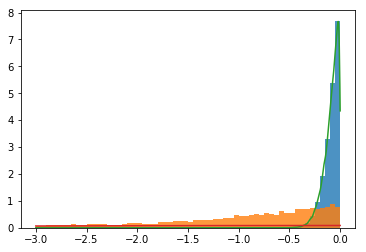

In [62]:

hist_args['range'] = (-3,0)
plt.hist(trace['effect_size'], **hist_args)
plt.hist(trace['prior_effect_size'], **hist_args)
kde_prior_effect = stats.gaussian_kde(trace['prior_effect_size'])
kde_effect = stats.gaussian_kde(trace['effect_size'])
kde_plot_x = np.linspace(-3, 0, 1000)
plt.plot(kde_plot_x, kde_effect(kde_plot_x))
#TODO find method to provide smooth estimates for cauchy priors
plt.plot(kde_plot_x, kde_prior_effect(kde_plot_x))
#indicates stong evidence in support of Ho - effect size = 0 relative to H1 effect size ~Cauchy(0,1)I(-inf,0)

In [64]:
#example 8.3- two sample comparison of memory performance between normal water consumers - control
# and oxygenated water consumers
exp = [70, 80, 79,83, 77, 75, 84, 78, 75, 75, 78, 82, 74, 81, 72, 70, 75, 72, 76, 77];
control = [56, 80, 63, 62, 67, 71, 68, 76, 79, 67, 76, 74, 67, 70, 62, 65, 72, 72, 69, 71];
with pm.Model() as model:
    mu = pm.Cauchy('mu',alpha=0, beta=1)
    effect_size = pm.Cauchy('effect_size', alpha=0, beta=1)
    std_dev = pm.HalfCauchy('std', beta=1)
    std_dev_prior = pm.HalfCauchy('std_prior', beta=1)
    #modeling difference between groups
    mean_difference = std_dev*effect_size
    
    #use effect size (with variance) to model difference between two distributions
    control_norm = pm.Normal('control', mu=mu-mean_difference/2, sd=std_dev, observed=control)
    exp_norm = pm.Normal('exp', mu=mu+mean_difference/2, sd=std_dev, observed=exp)
    prior_norm = pm.Normal('prior', mu=0, sd=2)
    
    

In [65]:
with model:
   trace = pm.sample(20000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [prior, std_prior, std, effect_size, mu]
Sampling 2 chains: 100%|██████████| 41000/41000 [01:01<00:00, 667.21draws/s]
/anaconda3/lib/python3.7/site-packages/mkl_fft/_numpy_fft.py:1044: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  output = mkl_fft.rfftn_numpy(a, s, axes)


(-3, 3)

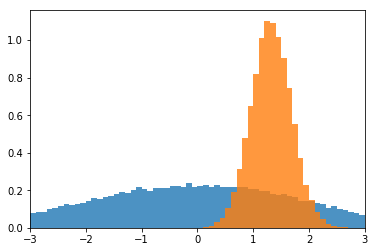

In [66]:
#very strong support for H1 that there is an effect of drinking oxygenated water using savage dickey method
hist_args['range']=(-3,3)
plt.hist(trace['prior'], **hist_args)
plt.hist(trace['effect_size'], **hist_args)
plt.xlim(-3,3)